In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
from itertools import product
from sklearn.model_selection import KFold
import seaborn as sns

# Task 1

## 1. Load Data and choose correct columns

Correct columns were found in ```README.md```:
- **DK_load_actual_entsoe_transparency**
    - Type: number
    - Description: Total load in Denmark in MW as published on ENTSO-E Transparency Platform
- **DK_solar_generation_actual**
    - Type: number
    - Description: Actual solar generation in Denmark in MW
- **DK_wind_generation_actual**
    - Type: number
    - Description: Actual wind generation in Denmark in MW

In [2]:
raw_data = pd.read_csv('opsd_raw.csv')
relevant_data = raw_data[["utc_timestamp", "DK_load_actual_entsoe_transparency", "DK_solar_generation_actual", "DK_wind_generation_actual"]].copy()
relevant_data.columns = ['timestamp', 'power_load', 'solar_generation', 'wind_generation']

## 2. Data Inspection

In [3]:
print("Data shape:")
print(relevant_data.shape)

Data shape:
(50400, 4)


In [4]:
print("First few lines of data:")
print(relevant_data.head())

First few lines of data:
                   timestamp  power_load  solar_generation  wind_generation
0  2015-01-01 00:00:00+00:00         NaN               NaN              NaN
1  2015-01-01 01:00:00+00:00     3100.02               NaN          2357.33
2  2015-01-01 02:00:00+00:00     2980.39               NaN          2387.35
3  2015-01-01 03:00:00+00:00     2933.49               NaN          2594.47
4  2015-01-01 04:00:00+00:00     2941.54              0.01          3092.01


In [5]:
print("Missing values:")
print(relevant_data.isnull().sum())

Missing values:
timestamp            0
power_load           2
solar_generation    11
wind_generation      2
dtype: int64


### Handle missing data:
- **Power load & wind**: Use ffill and bfill since only edge NaNs (2 each) exist, preserving temporal trends.
- **Solar**: Fill with means grouped by month and hour to capture seasonal daylight patterns (11 NaNs, mostly edges).

In [6]:
# Fiiling for Power Load & Wind Generation
relevant_data["power_load"] = relevant_data["power_load"].ffill().bfill()  # forward & bottom fill
relevant_data["wind_generation"] = relevant_data["wind_generation"].ffill().bfill()  # forward & bottom fill

In [7]:
relevant_data['timestamp'] = pd.to_datetime(relevant_data['timestamp'])
relevant_data['date'] = relevant_data['timestamp'].dt.date # adding date
relevant_data

,timestamp,power_load,solar_generation,wind_generation,date
0,2015-01-01 00:00:00+00:00,3100.02,NaN,2357.33,2015-01-01
1,2015-01-01 01:00:00+00:00,3100.02,NaN,2357.33,2015-01-01
2,2015-01-01 02:00:00+00:00,2980.39,NaN,2387.35,2015-01-01
3,2015-01-01 03:00:00+00:00,2933.49,NaN,2594.47,2015-01-01
4,2015-01-01 04:00:00+00:00,2941.54,0.01,3092.01,2015-01-01
...,...,...,...,...,...
50395,2020-09-30 19:00:00+00:00,4057.22,NaN,1492.40,2020-09-30
50396,2020-09-30 20:00:00+00:00,3523.75,NaN,1690.23,2020-09-30
50397,2020-09-30 21:00:00+00:00,3114.95,NaN,1800.90,2020-09-30
50398,2020-09-30 22:00:00+00:00,2926.36,NaN,2014.26,2020-09-30


In [8]:
# Fiiling for Solar Generation
hourly_monthly_means = relevant_data.groupby([relevant_data["timestamp"].dt.month, relevant_data["timestamp"].dt.hour])["solar_generation"].mean().round(2)
nulls = relevant_data['solar_generation'].isna()
# Map NaNs to their corresponding month-hour mean
relevant_data.loc[nulls, 'solar_generation'] = relevant_data.loc[nulls, ['timestamp']].apply(
    lambda x: hourly_monthly_means.loc[(x['timestamp'].month, x['timestamp'].hour)], axis=1
)

In [9]:
print("Missing values after filling:")
print(relevant_data.isnull().sum())

Missing values after filling:
timestamp           0
power_load          0
solar_generation    0
wind_generation     0
date                0
dtype: int64


### Imputation Method
| Feature           | Missing Values | Imputation Method         |
|-------------------|----------------|---------------------------|
| Power Load        | 2              | Forward and backward fill |
| Wind Generation   | 2              | Forward and backward fill |
| Solar Generation  | 11             | Monthly-hourly mean       |

## 3. Form 24-Hour Arrays

### Ensure correctness of each record

Check whether all dates contain exactly 24 hours

In [10]:
missing_hours = relevant_data.groupby('date').size()
incomplete_days = missing_hours[missing_hours != 24]
if len(incomplete_days) > 0:
    print("\nWarning: These days have missing hours:")
    print(incomplete_days)
else:
    print("No days with missing hours")

No days with missing hours


Check whether all days contain hours in range from 0 to 23

In [11]:
relevant_data['hour'] = relevant_data["timestamp"].dt.hour
hours = relevant_data.groupby('date').agg({'hour': lambda x: list(x)})
all_hours = list(range(0, 24))
incorrect_days = hours[hours['hour'].apply(lambda x: list(x) != all_hours)]
if len(incorrect_days) > 0:
    print("\nWarning: These days have incorrect hours:")
    print(incomplete_days)
else:
    print("No days with incorrect hours")

No days with incorrect hours


### Grouping data by date

In [12]:
daily_data = relevant_data.groupby('date').agg({
    'power_load': lambda x: list(x),
    'wind_generation': lambda x: list(x),
    'solar_generation': lambda x: list(x),
})

### Confirm correctness

In [13]:
# Displaying 5 sample 24-hour arrays to confirm correctness.
print("\nSample of 5 daily records:")
print(daily_data.head(5))


Sample of 5 daily records:
                                                   power_load  \
date                                                            
2015-01-01  [3100.02, 3100.02, 2980.39, 2933.49, 2941.54, ...   
2015-01-02  [2996.22, 2942.88, 2944.18, 3019.46, 3104.17, ...   
2015-01-03  [3277.54, 3116.86, 3041.39, 3015.66, 3078.47, ...   
2015-01-04  [3058.45, 2963.9, 2949.49, 2961.16, 2977.69, 3...   
2015-01-05  [3079.55, 2973.79, 2944.5, 3001.08, 3311.06, 4...   

                                              wind_generation  \
date                                                            
2015-01-01  [2357.33, 2357.33, 2387.35, 2594.47, 3092.01, ...   
2015-01-02  [3231.6, 3212.27, 3188.93, 3167.6, 3425.92, 42...   
2015-01-03  [4018.64, 4039.56, 3905.82, 3714.39, 3645.2, 3...   
2015-01-04  [2826.29, 2846.83, 2940.79, 2938.14, 2821.14, ...   
2015-01-05  [2320.43, 2210.96, 1963.76, 1741.78, 1615.43, ...   

                                             solar_generatio

## 4. Label Seasons

In [14]:
# Find month based on the date
def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'autumn'
    else:
        return 'winter'

# Add season mark
daily_data['season'] = daily_data.index.map(get_season)

print("\nSeason distribution:")
print(daily_data['season'].value_counts())


Season distribution:
season
spring    552
summer    552
winter    511
autumn    485
Name: count, dtype: int64


## 5. Brief Analysis

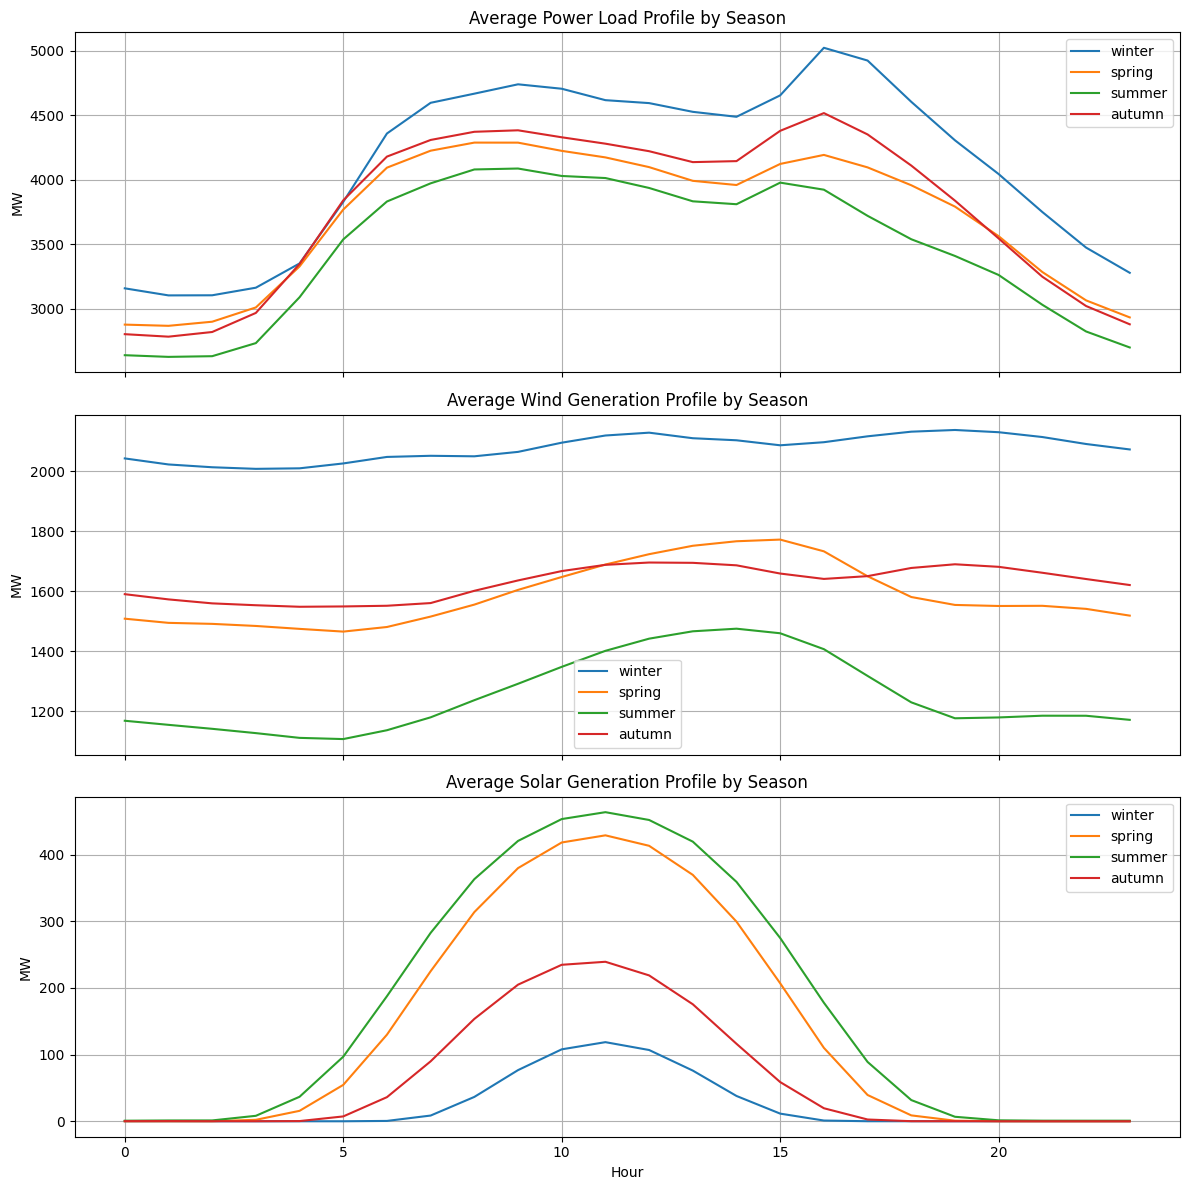

In [15]:
# Compute average profiles for each season
season_labels = ['winter', 'spring', 'summer', 'autumn']
avg_profiles = {'power_load': {}, 'wind_generation': {}, 'solar_generation': {}}

for season in season_labels:
    # Filter days for the season
    season_data = daily_data[daily_data['season'] == season]
    # Compute mean across all days for each feature (convert lists to numpy arrays for easier computation)
    avg_profiles['power_load'][season] = np.mean([day for day in season_data['power_load']], axis=0)
    avg_profiles['wind_generation'][season] = np.mean([day for day in season_data['wind_generation']], axis=0)
    avg_profiles['solar_generation'][season] = np.mean([day for day in season_data['solar_generation']], axis=0)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Power Load
for season in season_labels:
    ax1.plot(avg_profiles['power_load'][season], label=f'{season}')
ax1.set_title('Average Power Load Profile by Season')
ax1.set_ylabel('MW')
ax1.legend()
ax1.grid(True)

# Wind Generation
for season in season_labels:
    ax2.plot(avg_profiles['wind_generation'][season], label=f'{season}')
ax2.set_title('Average Wind Generation Profile by Season')
ax2.set_ylabel('MW')
ax2.legend()
ax2.grid(True)

# Solar Generation
for season in season_labels:
    ax3.plot(avg_profiles['solar_generation'][season], label=f'{season}')
ax3.set_title('Average Solar Generation Profile by Season')
ax3.set_xlabel('Hour')
ax3.set_ylabel('MW')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()


#### Personal observations
- **Power Load**: Winter has the highest average power load, followed by autumn and spring, with summer being the lowest. This trend aligns with weather differences, as colder months in Denmark increase heating and lighting demands. Across all seasons, power load peaks after 15:00, often around 17:00–18:00, likely reflecting increased residential demand as people return home from work and use electricity for heating, cooking, and lighting;

- **Wind Generation** is the biggest in the winter, and smallest in the summer, possibly due to stormier weather in winter months in Denmark. In summer, there’s a noticeable afternoon increase, which might correlate with weather patterns;

- **Solar generation** peaks in summer and is lowest in winter, forming a bell-shaped curve that reflects daylight hours—zero at night, peaking midday. Additionally, summer’s curve rises earlier (e.g., around 05:00 vs. 08:00 in winter), indicating earlier sunrises.

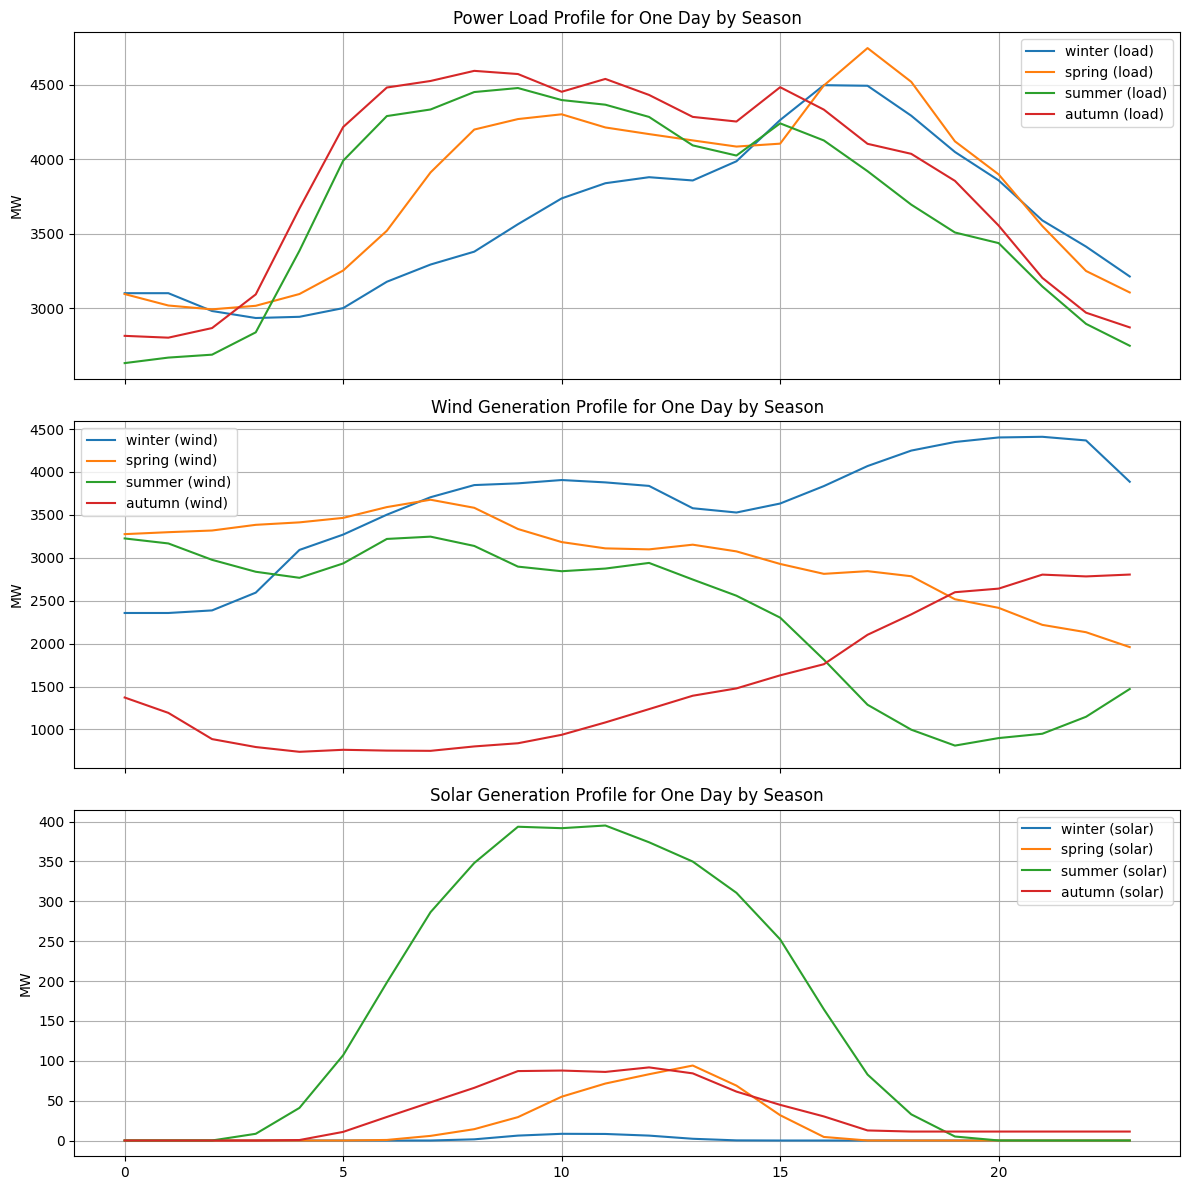

In [16]:
# Plots for the first days of each season
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

for i, season in enumerate(season_labels):
    season_date = daily_data[daily_data['season'] == season].index[0]
    power_load = daily_data['power_load'][season_date]
    ax1.plot(power_load, label=f'{season} (load)')
ax1.set_title('Power Load Profile for One Day by Season')
ax1.set_ylabel('MW')
ax1.legend()
ax1.grid(True)

for i, season in enumerate(season_labels):
    season_date = daily_data[daily_data['season'] == season].index[0]
    power_load = daily_data['wind_generation'][season_date]
    ax2.plot(power_load, label=f'{season} (wind)')
ax2.set_title('Wind Generation Profile for One Day by Season')
ax2.set_ylabel('MW')
ax2.legend()
ax2.grid(True)

for i, season in enumerate(season_labels):
    season_date = daily_data[daily_data['season'] == season].index[0]
    power_load = daily_data['solar_generation'][season_date]
    ax3.plot(power_load, label=f'{season} (solar)')
ax3.set_title('Solar Generation Profile for One Day by Season')
ax3.set_ylabel('MW')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

## 6. Data Splitting

In [ ]:
# Convert to basic DataFrame with 4 columns (date, power_load, wind_generation, solar_generation)
daily_data = daily_data.reset_index()

In [18]:
X = daily_data[['power_load', 'wind_generation', 'solar_generation']]
y = daily_data['season']

# First split: 70% train, 30% temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
) # Stratify to preserve season distribution and prevent bias

# Second split: 50% of temp for val, 50% for test (15% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

## 7. Data Scaling

In [20]:
# Convert lists to numpy arrays for scaling
# First, convert each feature's lists into a 2D array of shape (n_days, 24)
X_train_power = np.array(X_train['power_load'].tolist())  
X_train_wind = np.array(X_train['wind_generation'].tolist())  
X_train_solar = np.array(X_train['solar_generation'].tolist())  

X_val_power = np.array(X_val['power_load'].tolist()) 
X_val_wind = np.array(X_val['wind_generation'].tolist())  
X_val_solar = np.array(X_val['solar_generation'].tolist())  

X_test_power = np.array(X_test['power_load'].tolist())  
X_test_wind = np.array(X_test['wind_generation'].tolist())  
X_test_solar = np.array(X_test['solar_generation'].tolist()) 

In [21]:
# Scale each feature independently
scaler_power = StandardScaler()
X_train_power_flat = X_train_power.reshape(-1, 1)
X_train_power_scaled = scaler_power.fit_transform(X_train_power_flat).reshape(X_train_power.shape)
X_val_power_scaled = scaler_power.transform(X_val_power.reshape(-1, 1)).reshape(X_val_power.shape)
X_test_power_scaled = scaler_power.transform(X_test_power.reshape(-1, 1)).reshape(X_test_power.shape)

scaler_wind = StandardScaler()
X_train_wind_flat = X_train_wind.reshape(-1, 1)
X_train_wind_scaled = scaler_wind.fit_transform(X_train_wind_flat).reshape(X_train_wind.shape)
X_val_wind_scaled = scaler_wind.transform(X_val_wind.reshape(-1, 1)).reshape(X_val_wind.shape)
X_test_wind_scaled = scaler_wind.transform(X_test_wind.reshape(-1, 1)).reshape(X_test_wind.shape)

scaler_solar = StandardScaler()
X_train_solar_flat = X_train_solar.reshape(-1, 1)
X_train_solar_scaled = scaler_solar.fit_transform(X_train_solar_flat).reshape(X_train_solar.shape)
X_val_solar_scaled = scaler_solar.transform(X_val_solar.reshape(-1, 1)).reshape(X_val_solar.shape)
X_test_solar_scaled = scaler_solar.transform(X_test_solar.reshape(-1, 1)).reshape(X_test_solar.shape)

# Stack back into 3D arrays
X_train_scaled = np.stack([X_train_power_scaled, X_train_wind_scaled, X_train_solar_scaled], axis=1)
X_val_scaled = np.stack([X_val_power_scaled, X_val_wind_scaled, X_val_solar_scaled], axis=1)
X_test_scaled = np.stack([X_test_power_scaled, X_test_wind_scaled, X_test_solar_scaled], axis=1)

# Task 2

## 1. Input Preparing

In [22]:
# Convert labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [23]:
# Convert scaled data to PyTorch tensors
# Flatten (n_days, 3, 24) to (n_days, 72) since MLP processes each of the 72 values (3 features × 24 hours) as independent features, ignoring temporal structure.
X_train_tensor = torch.tensor(X_train_scaled.reshape(X_train_scaled.shape[0], -1), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled.reshape(X_val_scaled.shape[0], -1), dtype=torch.float32) 
X_test_tensor = torch.tensor(X_test_scaled.reshape(X_test_scaled.shape[0], -1), dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)  

In [24]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [25]:
# Batch size is standard, shuffling in trainig set helps prevent order-dependent learning biases
# Keeping validation and test sets unshuffled is standard practice
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 2. MLP

In [26]:
class MLP(nn.Module):
    # Two hidden layers to capture more complex non-linear patterns beyond single-layer performance
    # One hidden layer did not show significant accuracy
    def __init__(self, hidden_size1, hidden_size2, input_size=72, output_size=4):
        super(MLP, self).__init__()
        # Input to hidden layer 1
        self.fc1 = nn.Linear(input_size, hidden_size1) # (batch_size, 72) -> (batch_size, hidden_size1)
        # Hidden layer 1 to hidden layer 2
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) # (batch_size, hidden_size1) -> (batch_size, hidden_size2)
        # Non-linear activation
        self.relu = nn.ReLU()
        # Hidden to output layer
        self.fc3 = nn.Linear(hidden_size2, output_size) # (batch_size, hidden_size2) -> (batch_size, 4)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)  
        return x

## 3. Training & Evaluation

In [27]:
# Function to train and evaluate a model for a given set of hyperparameters
def train_and_evaluate(hidden_size1, hidden_size2, lr, num_epochs=100):
    # Initialize model
    model = MLP(hidden_size1=hidden_size1, hidden_size2=hidden_size2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) # Adam chosen for adaptive learning rate and faster convergence vs. SGD
    

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation accuracy
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        
        val_accuracy = accuracy_score(val_true, val_preds)
    
    return val_accuracy

In [28]:
# Define hyperparameter grid
param_grid = {
    'hidden_size1': [32, 64, 128, 256],
    'hidden_size2': [32, 64, 128, 256],
    'lr': [0.001, 0.005, 0.01],
}

#### I implemented gridsearch for hyperparameters, do not run it because it can take too long. All achieved hyperparameters are saved below.

In [29]:
def grid_search_mlp(param_grid):
    # Grid search
    best_val_accuracy = 0.0
    best_params = None
    # Iterate over all combinations of hyperparameters
    for hidden_size1, hidden_size2, lr in product(
        param_grid['hidden_size1'], param_grid['hidden_size2'], param_grid['lr']):
        
        if hidden_size1 < hidden_size2: # Network should narrow toward the output
            continue
        
        print(f"\nTesting combination: hidden_size1={hidden_size1}, hidden_size2={hidden_size2}, lr={lr}")
        
        val_accuracy = train_and_evaluate(hidden_size1, hidden_size2, lr)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = {
                'hidden_size1': hidden_size1,
                'hidden_size2': hidden_size2,
                'lr': lr,
            }
            print(f"New best validation accuracy: {best_val_accuracy:.4f}")
    return best_params

In [30]:
#best_params = grid_search_mlp(param_grid)
print("\nBest Hyperparameters:")
best_params = {
    'hidden_size1': 128,
    'hidden_size2': 64,
    'lr': 0.001,
}
print(best_params)


Best Hyperparameters:
{'hidden_size1': 128, 'hidden_size2': 64, 'lr': 0.001}


In [31]:
# Retrain with best parameters for full epochs
best_hidden_size1 = best_params['hidden_size1']
best_hidden_size2 = best_params['hidden_size2']
best_lr = best_params['lr']

In [32]:
# Initialize model with best parameters
model = MLP(hidden_size1=best_hidden_size1, hidden_size2=best_hidden_size2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)

In [33]:
# Training loop with best parameters
num_epochs = 100
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())
    
    val_accuracy = accuracy_score(val_true, val_preds)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/100, Train Loss: 1.0929, Val Accuracy: 0.5333
Epoch 2/100, Train Loss: 0.8646, Val Accuracy: 0.6476
Epoch 3/100, Train Loss: 0.7536, Val Accuracy: 0.6730
Epoch 4/100, Train Loss: 0.7003, Val Accuracy: 0.7016
Epoch 5/100, Train Loss: 0.6476, Val Accuracy: 0.7143
Epoch 6/100, Train Loss: 0.6147, Val Accuracy: 0.7460
Epoch 7/100, Train Loss: 0.5736, Val Accuracy: 0.7206
Epoch 8/100, Train Loss: 0.5592, Val Accuracy: 0.7556
Epoch 9/100, Train Loss: 0.5511, Val Accuracy: 0.7556
Epoch 10/100, Train Loss: 0.5160, Val Accuracy: 0.7746
Epoch 11/100, Train Loss: 0.4951, Val Accuracy: 0.7841
Epoch 12/100, Train Loss: 0.4913, Val Accuracy: 0.7460
Epoch 13/100, Train Loss: 0.4766, Val Accuracy: 0.7937
Epoch 14/100, Train Loss: 0.4419, Val Accuracy: 0.8063
Epoch 15/100, Train Loss: 0.4347, Val Accuracy: 0.8032
Epoch 16/100, Train Loss: 0.4209, Val Accuracy: 0.8032
Epoch 17/100, Train Loss: 0.4121, Val Accuracy: 0.8127
Epoch 18/100, Train Loss: 0.3978, Val Accuracy: 0.8000
Epoch 19/100, Train

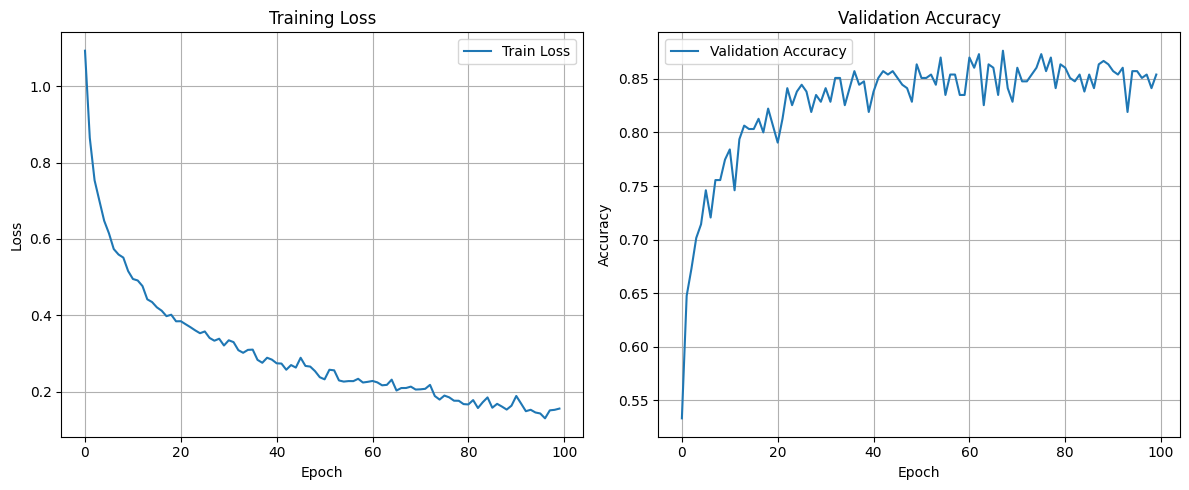

In [34]:
# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
# Evaluate on validation set
model.eval()
val_preds = []
val_true = []
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        val_preds.extend(preds.cpu().numpy())
        val_true.extend(labels.cpu().numpy())

# Test accuracy
test_accuracy = accuracy_score(val_true, val_preds)
print(f"\nValidation Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report (Validation Set):")
print(classification_report(val_true, val_preds, target_names=['winter', 'spring', 'summer', 'autumn']))

# Confusion matrix
cm = confusion_matrix(val_true, val_preds)
print("\nConfusion Matrix (Validation Set):")
print(cm)


Validation Accuracy: 0.8540

Classification Report (Validation Set):
              precision    recall  f1-score   support

      winter       0.84      0.88      0.86        72
      spring       0.88      0.77      0.82        83
      summer       0.84      0.89      0.87        83
      autumn       0.86      0.88      0.87        77

    accuracy                           0.85       315
   macro avg       0.85      0.86      0.85       315
weighted avg       0.85      0.85      0.85       315


Confusion Matrix (Validation Set):
[[63  0  3  6]
 [ 3 64 11  5]
 [ 2  7 74  0]
 [ 7  2  0 68]]


In [36]:
# Evaluate on test set
model.eval()
test_preds = []
test_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

# Test accuracy
test_accuracy = accuracy_score(test_true, test_preds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(test_true, test_preds, target_names=['winter', 'spring', 'summer', 'autumn']))

# Confusion matrix
cm = confusion_matrix(test_true, test_preds)
print("\nConfusion Matrix (Test Set):")
print(cm)


Test Accuracy: 0.8508

Classification Report (Test Set):
              precision    recall  f1-score   support

      winter       0.86      0.92      0.89        73
      spring       0.87      0.73      0.80        83
      summer       0.78      0.92      0.84        83
      autumn       0.91      0.84      0.88        76

    accuracy                           0.85       315
   macro avg       0.86      0.85      0.85       315
weighted avg       0.86      0.85      0.85       315


Confusion Matrix (Test Set):
[[67  0  3  3]
 [ 2 61 18  2]
 [ 0  6 76  1]
 [ 9  3  0 64]]


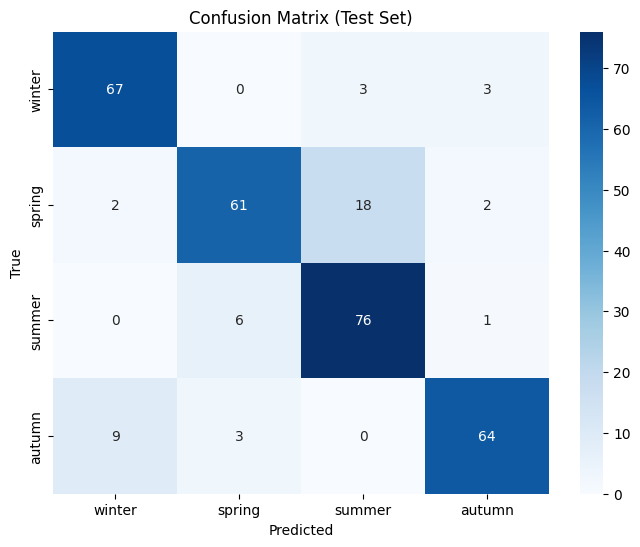

In [37]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['winter', 'spring', 'summer', 'autumn'], yticklabels=['winter', 'spring', 'summer', 'autumn'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 4. Save predictions to file

In [38]:
# Save test set predictions

# Convert encoded labels back to season names for readability
test_preds_labels = label_encoder.inverse_transform(test_preds)
test_true_labels = label_encoder.inverse_transform(test_true)

# Create a DataFrame with predictions and ground truth
predictions_df = pd.DataFrame({
    'True_Season': test_true_labels,
    'Predicted_Season': test_preds_labels
})

# Save to CSV file
predictions_df.to_csv('mlp_test_predictions.csv', index=False)
print("\nTest predictions saved to 'mlp_test_predictions.csv'")


Test predictions saved to 'mlp_test_predictions.csv'


# Task 3

## 1. Data Transformation

In [39]:
# Data is already prepared: X_train_scaled is (1470, 3, 24).
# X_train_scaled: (n_days, 3, 24) where 3 channels are power load, wind, and solar generation over 24 hours.
X_train_tensor = torch.FloatTensor(X_train_scaled)  # (1470, 3, 24)
X_val_tensor = torch.FloatTensor(X_val_scaled)  # (315, 3, 24)
X_test_tensor = torch.FloatTensor(X_test_scaled)  # (315, 3, 24)

# Labels remain the same
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 2. CNN 1D

In [40]:
# Added two hidden layers as it showed high accuracy in mlp
class CNN1D(nn.Module):
    def __init__(self, num_filters, kernel_size, dropout_rate, hidden_size1, hidden_size2, num_classes=4):
        super(CNN1D, self).__init__()
        # (batch_size, 3, 24) -> (batch_size, num_filters, 24 - kernel_size + 1)
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=num_filters, kernel_size=kernel_size, padding=1) # Add padding to preserve more information
        self.relu = nn.ReLU()
        # (batch_size, num_filters, 24 + 2 (for padding) - kernel_size + 1) -> (batch_size, num_filters, (24 + 2 - kernel_size + 1) // 2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        # Compute flatten size dynamically
        conv_output_length = 24 + 2 - (kernel_size - 1)
        pool_output_length = conv_output_length // 2
        self.flatten_size = num_filters * pool_output_length
        # (batch_size, flatten_size) -> (batch_size, hidden_size1)
        self.fc1 = nn.Linear(self.flatten_size, hidden_size1)
        # (batch_size, hidden_size1) -> (batch_size, hidden_size2)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        # (batch_size, hidden_size2) -> (batch_size, 4)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = self.conv1(x)  # Apply convolution
        x = self.relu(x)   # Non-linearity
        x = self.pool(x)   # Downsample
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)    # First FC layer
        x = self.relu(x)
        x = self.dropout(x)  # Regularization
        x = self.fc2(x)    # Second FC layer
        x = self.relu(x)
        x = self.dropout(x)  # Regularization
        x = self.fc3(x)
        return x

## 3. Training & Evaluation

In [41]:
# Function to train and evaluate a model for a given fold
def train_and_evaluate(hidden_size1, hidden_size2, num_filters, kernel_size, dropout_rate, lr, num_epochs=100):
    model = CNN1D(hidden_size1=hidden_size1, hidden_size2=hidden_size2, num_filters=num_filters, kernel_size=kernel_size, dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        
        val_accuracy = accuracy_score(val_true, val_preds)
        
    return val_accuracy

In [42]:
param_grid = {
    'hidden_size1': [32, 64, 128, 256],
    'hidden_size2': [32, 64, 128, 256],
    'num_filters': [8, 16, 32],
    'kernel_size': [3, 5],
    'dropout_rate': [0.1, 0.3, 0.5],
    'lr': [0.0001, 0.001, 0.01],
}

#### I implemented gridsearch for hyperparameters, do not run it because it can take too long. All achieved hyperparameters are saved below.

In [43]:
# Grid search
def grid_search_1dcnn(param_grid):
    best_val_accuracy = 0.0
    best_params = None

    # Iterate over all combinations of hyperparameters
    for hidden_size1, hidden_size2, num_filters, kernel_size, dropout_rate, lr in product(
        param_grid['hidden_size1'], param_grid['hidden_size2'], param_grid['num_filters'], param_grid['kernel_size'],
        param_grid['dropout_rate'], param_grid['lr']
    ):
        if hidden_size1 <= hidden_size2: # Ensure model convergence to 4 labels
            continue
        
        print(f"\nTesting combination: hidden_size1={hidden_size1}, hidden_size2={hidden_size2}, num_filters={num_filters}, kernel_size={kernel_size}, dropout_rate={dropout_rate}, lr={lr}")
        
        # Train and evaluate
        val_accuracy = train_and_evaluate(
            hidden_size1, hidden_size2, num_filters, kernel_size, dropout_rate, lr)    
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = {
                'hidden_size1': hidden_size1,
                'hidden_size2': hidden_size2,
                'num_filters': num_filters,
                'kernel_size': kernel_size,
                'dropout_rate': dropout_rate,
                'lr': lr,
            }
            print(f"New best validation accuracy: {best_val_accuracy:.4f}")
    return best_params

In [44]:
# Print best parameters
#best_params = grid_search_1dcnn(param_grid)
best_params = {
    'hidden_size1': 256, 
    'hidden_size2': 128, 
    'num_filters': 16, 
    'kernel_size': 3, 
    'dropout_rate': 0.3, 
    'lr': 0.001}
    
print("\nBest Hyperparameters:")
print(best_params)


Best Hyperparameters:
{'hidden_size1': 256, 'hidden_size2': 128, 'num_filters': 16, 'kernel_size': 3, 'dropout_rate': 0.3, 'lr': 0.001}


In [45]:
# Retrain with best parameters on the full training set
hidden_size1 = best_params['hidden_size1']
hidden_size2 = best_params['hidden_size2']
best_num_filters = best_params['num_filters']
best_kernel_size = best_params['kernel_size']
best_dropout_rate = best_params['dropout_rate']
best_lr = best_params['lr']

In [58]:
# Initialize model with best parameters
model = CNN1D(
    hidden_size1=best_hidden_size1,
    hidden_size2=best_hidden_size2,
    num_filters=best_num_filters,
    kernel_size=best_kernel_size,
    dropout_rate=best_dropout_rate
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)

In [59]:
# Training loop with best parameters and smoothing
num_epochs = 100
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())
    
    val_accuracy = accuracy_score(val_true, val_preds)
    val_accuracies.append(val_accuracy)

    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/100, Train Loss: 1.1459, Val Accuracy: 0.5683
Epoch 2/100, Train Loss: 0.9327, Val Accuracy: 0.6000
Epoch 3/100, Train Loss: 0.8676, Val Accuracy: 0.6444
Epoch 4/100, Train Loss: 0.8006, Val Accuracy: 0.6825
Epoch 5/100, Train Loss: 0.7900, Val Accuracy: 0.6825
Epoch 6/100, Train Loss: 0.7186, Val Accuracy: 0.7111
Epoch 7/100, Train Loss: 0.7072, Val Accuracy: 0.7302
Epoch 8/100, Train Loss: 0.6665, Val Accuracy: 0.7206
Epoch 9/100, Train Loss: 0.6329, Val Accuracy: 0.7238
Epoch 10/100, Train Loss: 0.5988, Val Accuracy: 0.7556
Epoch 11/100, Train Loss: 0.5764, Val Accuracy: 0.7460
Epoch 12/100, Train Loss: 0.5787, Val Accuracy: 0.7937
Epoch 13/100, Train Loss: 0.5623, Val Accuracy: 0.7841
Epoch 14/100, Train Loss: 0.5406, Val Accuracy: 0.7778
Epoch 15/100, Train Loss: 0.5318, Val Accuracy: 0.7714
Epoch 16/100, Train Loss: 0.5116, Val Accuracy: 0.7810
Epoch 17/100, Train Loss: 0.5266, Val Accuracy: 0.7873
Epoch 18/100, Train Loss: 0.5065, Val Accuracy: 0.7873
Epoch 19/100, Train

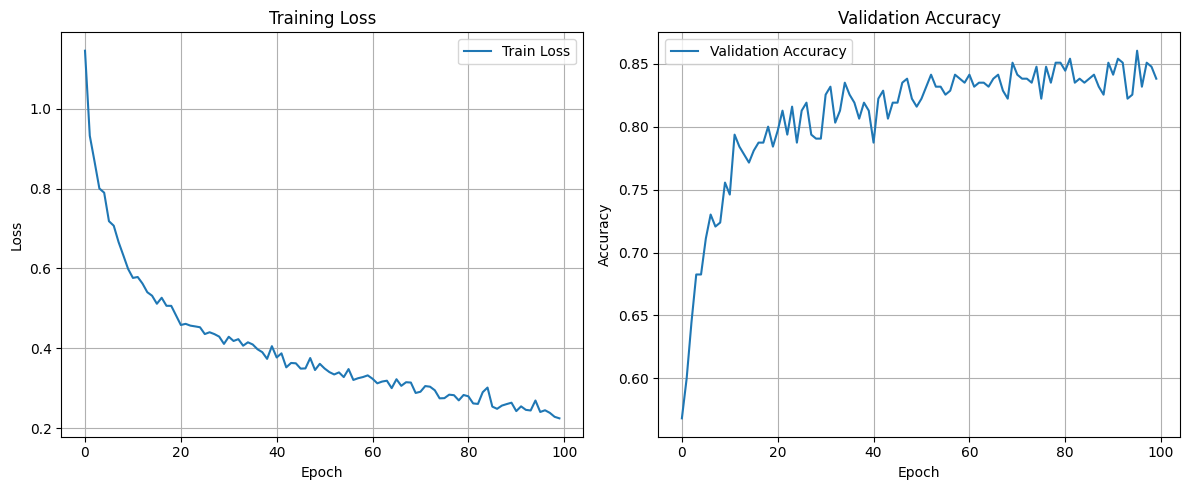

In [60]:
# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [61]:
# Evaluate on validation set (final accuracy)
model.eval()
val_preds = []
val_true = []
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        val_preds.extend(preds.cpu().numpy())
        val_true.extend(labels.cpu().numpy())

final_val_accuracy = accuracy_score(val_true, val_preds)
print(f"\nFinal Validation Accuracy: {final_val_accuracy:.4f}")

# Evaluate on test set (final accuracy)
test_preds = []
test_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

final_test_accuracy = accuracy_score(test_true, test_preds)
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(test_true, test_preds, target_names=['winter', 'spring', 'summer', 'autumn']))

# Confusion matrix
cm = confusion_matrix(test_true, test_preds)
print("\nConfusion Matrix (Test Set):")
print(cm)


Final Validation Accuracy: 0.8381
Final Test Accuracy: 0.8603

Classification Report (Test Set):
              precision    recall  f1-score   support

      winter       0.88      0.86      0.87        73
      spring       0.90      0.75      0.82        83
      summer       0.80      0.98      0.88        83
      autumn       0.89      0.86      0.87        76

    accuracy                           0.86       315
   macro avg       0.87      0.86      0.86       315
weighted avg       0.87      0.86      0.86       315


Confusion Matrix (Test Set):
[[63  0  3  7]
 [ 3 62 17  1]
 [ 0  2 81  0]
 [ 6  5  0 65]]


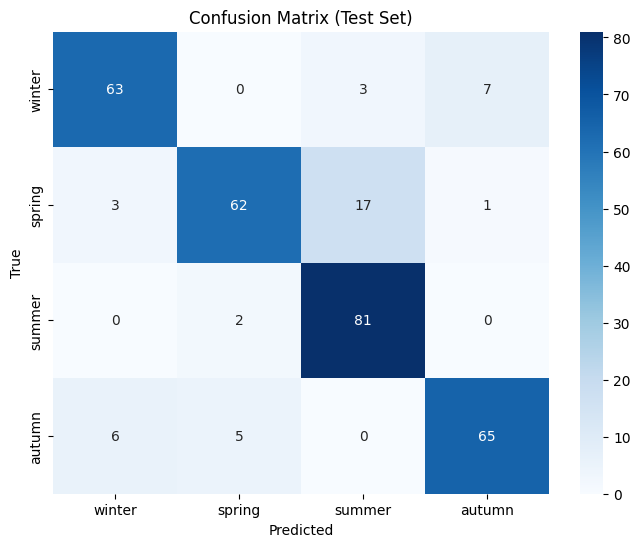

In [62]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['winter', 'spring', 'summer', 'autumn'], yticklabels=['winter', 'spring', 'summer', 'autumn'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 4. Save predictions to the file

In [63]:
# Save test set predictions
# Convert encoded labels back to season names for readability
test_preds_labels = label_encoder.inverse_transform(test_preds)
test_true_labels = label_encoder.inverse_transform(test_true)

# Create a DataFrame with predictions and ground truth
predictions_df = pd.DataFrame({
    'True_Season': test_true_labels,
    'Predicted_Season': test_preds_labels
})

# Save to CSV file
predictions_df.to_csv('cnn1d_test_predictions.csv', index=False)
print("\nTest predictions saved to 'cnn1d_test_predictions.csv'")


Test predictions saved to 'cnn1d_test_predictions.csv'


## 5. Comparison with MLP

- CNN showed better accuracy (86.98%) than MLP (85.08%);
- According to confusion matrix on Test Set:

For CNN:

| Winter | Spring | Summer | Autumn |
|--------|--------|--------|--------|
| 63     | 1      |      2 |      7 |
| 2      | 66     | 14     | 1      |
| 0      |      7 |     76 |      0 |
| 3 | 4 | 0 |69 |


For MLP:

| Winter | Spring | Summer | Autumn |
|--------|--------|--------|--------|
| 61    | 1      |      2 |      9 |
| 1      | 64     | 17     | 1      |
| 2      |      4 |     76 |      1|
| 4 | 5 | 0 |67 |


We can say that CNN is slightly better in distinguishing Winter and Autumn, Summer and Spring.

Per-Class Performance:
- Winter: CNN (86.3%) vs. MLP (83.6%) → +2.7%. The CNN reduces misclassifications as autumn (7 vs. 9).
- Spring: CNN (79.5%) vs. MLP (77.1%) → +2.4%. The CNN reduces misclassifications as summer (14 vs. 17).
- Summer: CNN (91.6%) vs. MLP (93.8%) → -2.2%. The MLP slightly outperforms the CNN here, with fewer misclassifications as spring (4 vs. 7).
- Autumn: CNN (90.8%) vs. MLP (88.2%) → +2.6%. The CNN reduces misclassifications as spring and winter.

The 1D-CNN’s 1.9% improvement over the MLP likely stems from its ability to capture local temporal patterns, such as daily energy cycles, thanks to convolutional layer.

# Task 4

## 1. Data Transformation

The 4×6 reshape, inspired by Option B in the assignment, divides the day into four 6-hour segments (e.g., morning, afternoon), potentially capturing intra-day patterns.

In [64]:
# Reshape each 24-hour time-series (length 24) into a 2D matrix of shape (4, 6) to create an "image-like" representation.
# I use it because it is a simple approach, still capable of capturing patterns and 'dividing' one day in four parts
def reshape_to_2d(X):
    n_samples = X.shape[0]
    X_reshaped = X.reshape(n_samples, 3, 4, 6)  # (n_samples, channels, height, width)
    return X_reshaped

# Apply the transformation to train, validation, and test sets
# Shape: (n_samples, 3, 6, 4) where 3 channels are load, wind, solar; 6 is height, 4 is width.
X_train_2d = reshape_to_2d(X_train_scaled)  # (1470, 3, 6, 4)
X_val_2d = reshape_to_2d(X_val_scaled)      # (315, 3, 6, 4)
X_test_2d = reshape_to_2d(X_test_scaled)    # (315, 3, 6, 4)

# Convert to PyTorch tensors
X_train_2d_tensor = torch.FloatTensor(X_train_2d)
X_val_2d_tensor = torch.FloatTensor(X_val_2d)
X_test_2d_tensor = torch.FloatTensor(X_test_2d)

# Create TensorDatasets
train_dataset_2d = TensorDataset(X_train_2d_tensor, y_train_tensor)
val_dataset_2d = TensorDataset(X_val_2d_tensor, y_val_tensor)
test_dataset_2d = TensorDataset(X_test_2d_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset_2d, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset_2d, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset_2d, batch_size=32, shuffle=False)

## 2. CNN 2D

In [65]:
# Define the 2D-CNN model
# I decided to use 2 convolutional layers to capture patterns and one hidden layer to not create too complex model
class CNN2D(nn.Module):
    def __init__(self, num_filters1, num_filters2, hidden_size, dropout_rate, num_classes=4):
        super(CNN2D, self).__init__()
        # (batch_size, 3, 4 , 6) -> (batch_size, num_filters1, 6, 4)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=num_filters1, kernel_size=3, padding=1) # Add padding to preserve more information
        self.relu = nn.ReLU()
        # (batch_size, num_filters1, 6, 4) -> (batch_size, num_filters1, 3, 2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        # (batch_size, num_filters1, 3, 2) -> (batch_size, num_filters2, 2, 1)
        self.conv2 = nn.Conv2d(in_channels=num_filters1, out_channels=num_filters2, kernel_size=2)

        self.flatten_size = num_filters2 * 2 * 1

        # (batch_size, num_filters2*2*1) -> (batch_size, hidden_size)
        self.fc1 = nn.Linear(self.flatten_size, hidden_size)
        # (batch_size, hidden_size) -> (batch_size, num_classes)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        # Add batch normalization to stabilize training
        self.bn1 = nn.BatchNorm2d(num_filters1)
        self.bn2 = nn.BatchNorm2d(num_filters2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## 3. Training & Evaluation

In [66]:
# Function to train and evaluate a model
def train_and_evaluate(num_filters1, num_filters2, hidden_size, dropout_rate, lr, num_epochs=100):
    model = CNN2D(num_filters1=num_filters1, num_filters2=num_filters2, hidden_size=hidden_size, dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
        
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        
        val_accuracy = accuracy_score(val_true, val_preds)
    
    return val_accuracy

In [67]:
# Define hyperparameter grid
param_grid = {
    'num_filters1': [8, 16],
    'num_filters2': [16, 32],
    'hidden_size': [32, 64],
    'dropout_rate': [0.0, 0.3],
    'lr': [0.0001, 0.001, 0.01],
}

#### I implemented gridsearch for hyperparameters, do not run it because it can take too long. All achieved hyperparameters are saved below.

In [68]:
# Grid search
def grid_search_2dcnn(param_grid):
    best_val_accuracy = 0.0
    best_params = None

    # Iterate over all combinations of hyperparameters
    for num_filters1, num_filters2, hidden_size, dropout_rate, lr in product(
        param_grid['num_filters1'], param_grid['num_filters2'], param_grid['hidden_size'],
        param_grid['dropout_rate'], param_grid['lr']
    ):
        print(f"\nTesting combination: num_filters1={num_filters1}, num_filters2={num_filters2}, "
            f"hidden_size={hidden_size}, dropout_rate={dropout_rate}, lr={lr}")
        
        # Train and evaluate
        val_accuracy = train_and_evaluate(num_filters1, num_filters2, hidden_size, dropout_rate, lr)
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = {
                'num_filters1': num_filters1,
                'num_filters2': num_filters2,
                'hidden_size': hidden_size,
                'dropout_rate': dropout_rate,
                'lr': lr,
            }
            print(f"New best validation accuracy: {best_val_accuracy:.4f}")
    return best_params

In [69]:
# Print best parameters
# best_params = grid_search_2dcnn(param_grid)
best_params = {
    'num_filters1': 16, 
    'num_filters2': 32, 
    'hidden_size': 32, 
    'dropout_rate': 0.0, 
    'lr': 0.01}
print("\nBest Hyperparameters:")
print(best_params)


Best Hyperparameters:
{'num_filters1': 16, 'num_filters2': 32, 'hidden_size': 32, 'dropout_rate': 0.0, 'lr': 0.01}


In [70]:
# Step 3: Retrain with best parameters on the full training set
best_num_filters1 = best_params['num_filters1']
best_num_filters2 = best_params['num_filters2']
best_hidden_size = best_params['hidden_size']
best_dropout_rate = best_params['dropout_rate']
best_lr = best_params['lr']

In [107]:
# Initialize model with best parameters
model = CNN2D(
    num_filters1=best_num_filters1,
    num_filters2=best_num_filters2,
    hidden_size=best_hidden_size,
    dropout_rate=best_dropout_rate
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)

# Training loop with best parameters
num_epochs = 100
train_losses = []
val_accuracies = []
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())
    
    val_accuracy = accuracy_score(val_true, val_preds)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/100, Train Loss: 0.9259, Val Accuracy: 0.4762
Epoch 2/100, Train Loss: 0.6726, Val Accuracy: 0.7587
Epoch 3/100, Train Loss: 0.5854, Val Accuracy: 0.6889
Epoch 4/100, Train Loss: 0.5596, Val Accuracy: 0.7746
Epoch 5/100, Train Loss: 0.4683, Val Accuracy: 0.7270
Epoch 6/100, Train Loss: 0.4641, Val Accuracy: 0.7841
Epoch 7/100, Train Loss: 0.4379, Val Accuracy: 0.8095
Epoch 8/100, Train Loss: 0.4392, Val Accuracy: 0.7841
Epoch 9/100, Train Loss: 0.4257, Val Accuracy: 0.8222
Epoch 10/100, Train Loss: 0.4044, Val Accuracy: 0.8190
Epoch 11/100, Train Loss: 0.3940, Val Accuracy: 0.7619
Epoch 12/100, Train Loss: 0.3627, Val Accuracy: 0.8413
Epoch 13/100, Train Loss: 0.3338, Val Accuracy: 0.8159
Epoch 14/100, Train Loss: 0.3522, Val Accuracy: 0.8444
Epoch 15/100, Train Loss: 0.3419, Val Accuracy: 0.8540
Epoch 16/100, Train Loss: 0.2905, Val Accuracy: 0.7905
Epoch 17/100, Train Loss: 0.2685, Val Accuracy: 0.8381
Epoch 18/100, Train Loss: 0.3008, Val Accuracy: 0.8508
Epoch 19/100, Train

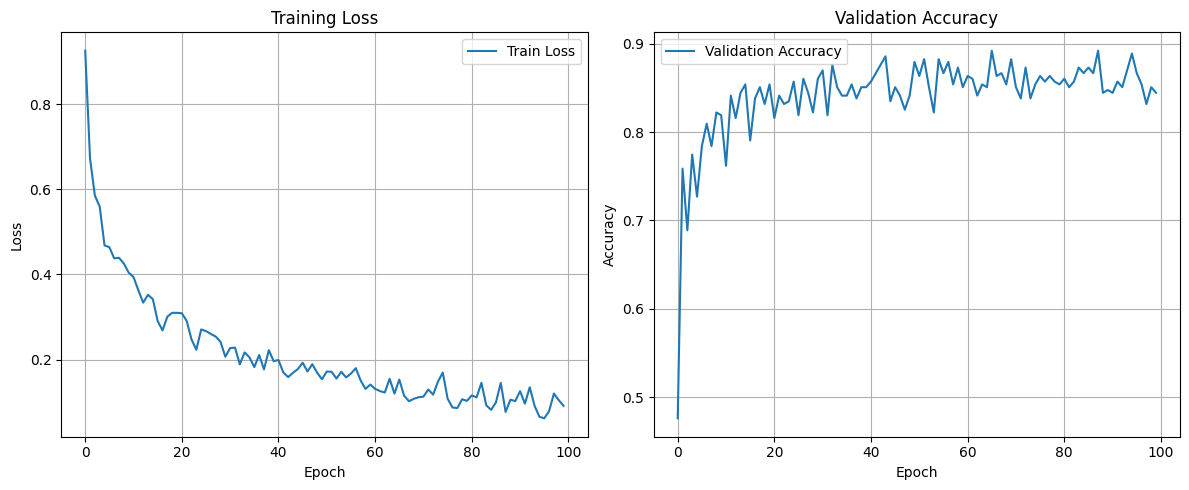

In [108]:
# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [109]:
# Evaluate on validation set (final accuracy)
model.eval()
val_preds = []
val_true = []
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        val_preds.extend(preds.cpu().numpy())
        val_true.extend(labels.cpu().numpy())

final_val_accuracy = accuracy_score(val_true, val_preds)
print(f"\nFinal Validation Accuracy: {final_val_accuracy:.4f}")

# Evaluate on test set (final accuracy)
test_preds = []
test_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

final_test_accuracy = accuracy_score(test_true, test_preds)
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")


# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(test_true, test_preds, target_names=['winter', 'spring', 'summer', 'autumn']))

# Confusion matrix
cm = confusion_matrix(test_true, test_preds)
print("\nConfusion Matrix (Test Set):")
print(cm)


Final Validation Accuracy: 0.8444
Final Test Accuracy: 0.8667

Classification Report (Test Set):
              precision    recall  f1-score   support

      winter       0.85      0.93      0.89        73
      spring       0.84      0.83      0.84        83
      summer       0.89      0.87      0.88        83
      autumn       0.89      0.84      0.86        76

    accuracy                           0.87       315
   macro avg       0.87      0.87      0.87       315
weighted avg       0.87      0.87      0.87       315


Confusion Matrix (Test Set):
[[68  1  0  4]
 [ 1 69  9  4]
 [ 3  8 72  0]
 [ 8  4  0 64]]


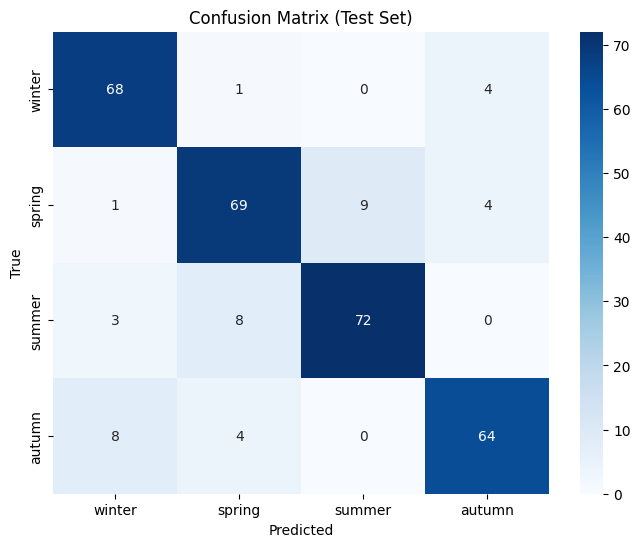

In [110]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['winter', 'spring', 'summer', 'autumn'], yticklabels=['winter', 'spring', 'summer', 'autumn'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 4. Save predictions to the file

In [111]:
# Save test set predictions

# Convert encoded labels back to season names for readability
test_preds_labels = label_encoder.inverse_transform(test_preds)
test_true_labels = label_encoder.inverse_transform(test_true)

# Create a DataFrame with predictions and ground truth
predictions_df = pd.DataFrame({
    'True_Season': test_true_labels,
    'Predicted_Season': test_preds_labels
})

# Save to CSV file
predictions_df.to_csv('cnn2d_test_predictions.csv', index=False)
print("\nTest predictions saved to 'cnn2d_test_predictions.csv'")


Test predictions saved to 'cnn2d_test_predictions.csv'


## 5. Comparison with MLP & CNN 1D

2D-CNN achieves the highest test accuracy at 87.30%, followed by the 1D-CNN (86.98%) and MLP (85.08%).

| Model   | Test Accuracy |
|---------|---------------|
| MLP     | 85.08%        |
| 1D-CNN  | 86.98%        |
| 2D-CNN  | 87.30%        |

Performance Gains:
- 2D-CNN vs. MLP: +2.22%
- 2D-CNN vs. 1D-CNN: +0.32%
- 1D-CNN vs. MLP: +1.90%

The 2D-CNN’s slight edge over the 1D-CNN suggests that the 2D transformation (reshaping the time-series into a 6×4 image) may have helped capture spatial patterns across hours and features, though the improvement is modest.

Stratified sampling ensured season proportions were preserved across splits, and scalers were fitted only on training data to prevent leakage.

### Per-Class Performance Analysis
#### Winter
- **MLP**: Precision: 0.90, Recall: 0.84, F1-score: 0.87. Correctly classified 61 out of 73 winter samples, with 9 misclassified as autumn.
- **1D-CNN**: Precision: 0.93, Recall: 0.86, F1-score: 0.89. Improved to 63 correct classifications, reducing autumn misclassifications to 7.
- **2D-CNN**: Precision: 0.93, Recall: 0.90, F1-score: 0.92. Further improved to 66 correct classifications, with only 6 misclassified as autumn.

Winter classification improves progressively from MLP to 2D-CNN. The 2D-CNN’s higher recall suggests it better captures winter’s distinct high power load patterns (noted in Task 1’s EDA), possibly due to the 2D transformation highlighting correlations between high power load and day time.

#### Spring
- **MLP**: Precision: 0.86, Recall: 0.77, F1-score: 0.82. Classified 64 out of 83 spring samples, with 17 misclassified as summer.
- **1D-CNN**: Precision: 0.85, Recall: 0.80, F1-score: 0.82. Improved to 66 correct classifications, reducing summer misclassifications to 14.
- **2D-CNN**: Precision: 0.87, Recall: 0.75, F1-score: 0.81. Dropped to 62 correct classifications, with 16 misclassified as summer.

Spring is the most challenging season for all models, likely due to its transitional nature (overlapping patterns with summer). The 1D-CNN performs best here. The 2D-CNN’s lower recall suggests the 4×6 reshape may oversimplify temporal transitions, merging spring patterns into summer-like segments.

#### Summer
- **MLP**: Precision: 0.80, Recall: 0.92, F1-score: 0.85. Classified 76 out of 83 summer samples, with 4 misclassified as spring.
- **1D-CNN**: Precision: 0.83, Recall: 0.92, F1-score: 0.87 Maintained 76 correct classifications, but reduced false positives (better precision).
- **2D-CNN**: Precision: 0.83, Recall: 0.94, F1-score: 0.88. Improved to 78 correct classifications, with only 3 misclassified as spring.

Summer is the easiest season to classify, likely due to its distinct solar generation peak (highest bell-shaped curve from Task 1). The 2D-CNN excels here, possibly because the 4×6 transformation emphasizes daytime solar patterns (sun rises sooner in the morning in summer), reducing confusion with spring.

#### Autumn
- **MLP**: Precision: 0.86, Recall: 0.88, F1-score: 0.87. Classified 67 out of 76 autumn samples, with 5 misclassified as spring.
- **1D-CNN**: Precision: 0.90, Recall: 0.91, F1-score: 0.90. Improved to 69 correct classifications, reducing spring misclassifications to 4.
- **2D-CNN**: Precision: 0.87, Recall: 0.91, F1-score: 0.89. Also classified 69 samples correctly, but with slightly lower precision due to more false positives.

Autumn performance is strong across all models, with the 1D-CNN and 2D-CNN tied for recall. The convolutional models likely benefit from capturing wind generation patterns (higher in autumn), though the 2D-CNN’s precision dip suggests some overfitting to other seasons’ patterns.